In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split #训练集，测试集划分函数
import torch
import torch.nn.functional as Fun
from matminer.featurizers.composition import alloy
from matminer.featurizers.conversions import StrToComposition
import pandas as pd

In [11]:
#设置超参数
lr=0.02 #学习率
epochs=300 #训练轮数
n_feature=6 #输入特征
n_hidden=20 #隐层节点数
n_output=1 #输出(鸢尾花三种类别)

In [12]:
# #1.准备数据
# iris=datasets.load_iris() #下载数据集
 
# #设置训练集数据80%，测试集20%
# x_train0,x_test0,y_train,y_test=train_test_split(iris.data,iris.target,test_size=0.2,random_state=22)
# #归一化(也就是所说的min-max标准化)通过调用sklearn库的标准化函数
# min_max_scaler = preprocessing.MinMaxScaler()
# x_train = min_max_scaler.fit_transform(x_train0)
# x_test = min_max_scaler.fit_transform(x_test0)
 
# #将数据类型转换为tensor方便pytorch使用
# x_train=torch.FloatTensor(x_train)
# y_train=torch.LongTensor(y_train)
# x_test=torch.FloatTensor(x_test)
# y_test=torch.LongTensor(y_test)

In [14]:
data = pd.read_csv('data.csv')

# Convert formula to composition
data = StrToComposition().featurize_dataframe(data, 'formula')
# 然后基于composition计算特征
data = alloy.WenAlloys().featurize_dataframe(data, 'composition')

StrToComposition:   0%|          | 0/799 [00:00<?, ?it/s]

WenAlloys:   0%|          | 0/799 [00:00<?, ?it/s]

In [16]:
data_fit = data.iloc[:600]
data_test = data.iloc[600:]

x_train0 = data_fit[['APE mean', 'Electronegativity local mismatch', 'VEC mean', 'Shear modulus mean', 'Shear modulus delta', 'Shear modulus strength model']]
y_train = data_fit[['SFE']]
x_test0 = data_test[['APE mean', 'Electronegativity local mismatch', 'VEC mean', 'Shear modulus mean', 'Shear modulus delta', 'Shear modulus strength model']]
y_test = data_test[['SFE']]

#归一化(也就是所说的min-max标准化)通过调用sklearn库的标准化函数
min_max_scaler = preprocessing.MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train0)
x_test = min_max_scaler.fit_transform(x_test0)
 
#将数据类型转换为tensor方便pytorch使用
x_train=torch.FloatTensor(x_train)
y_train=torch.FloatTensor(y_train.values)
x_test=torch.FloatTensor(x_test)
y_test=torch.FloatTensor(y_test.values)

In [19]:
#2.定义BP神经网络
class BPNetModel(torch.nn.Module):
    def __init__(self,n_feature,n_hidden,n_output):
        super(BPNetModel, self).__init__()
        self.hiddden=torch.nn.Linear(n_feature,n_hidden)#定义隐层网络
        self.out=torch.nn.Linear(n_hidden,n_output)#定义输出层网络
    def forward(self,x):
        x=Fun.relu(self.hiddden(x)) #隐层激活函数采用relu()函数
        out=Fun.softmax(self.out(x),dim=1) #输出层采用softmax函数
        return out
#3.定义优化器和损失函数
net=BPNetModel(n_feature=n_feature,n_hidden=n_hidden,n_output=n_output) #调用网络
optimizer=torch.optim.Adam(net.parameters(),lr=lr) #使用Adam优化器，并设置学习率
loss_fun=torch.nn.MSELoss() #对于多分类一般使用交叉熵损失函数

In [20]:
#4.训练数据
loss_steps=np.zeros(epochs) #构造一个array([ 0., 0., 0., 0., 0.])里面有epochs个0
accuracy_steps=np.zeros(epochs)
 
for epoch in range(epochs):
    y_pred=net(x_train) #前向传播
    loss=loss_fun(y_pred,y_train)#预测值和真实值对比
    optimizer.zero_grad() #梯度清零
    loss.backward() #反向传播
    optimizer.step() #更新梯度
    loss_steps[epoch]=loss.item()#保存loss
    running_loss = loss.item()
    print(f"第{epoch}次训练，loss={running_loss}".format(epoch,running_loss))
    with torch.no_grad(): #下面是没有梯度的计算,主要是测试集使用，不需要再计算梯度了
        y_pred=net(x_test)
        correct=(torch.argmax(y_pred,dim=1)==y_test).type(torch.FloatTensor)
        accuracy_steps[epoch]=correct.mean()
        print("测试鸢尾花的预测准确率", accuracy_steps[epoch])
 
#print("测试鸢尾花的预测准确率",accuracy_steps[-1])

第0次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第1次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第2次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第3次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第4次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第5次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第6次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第7次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第8次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第9次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第10次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第11次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第12次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第13次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第14次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第15次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第16次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第17次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第18次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第19次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第20次训练，loss=0.20691372454166412
测试鸢尾花的预测准确率 0.0
第2

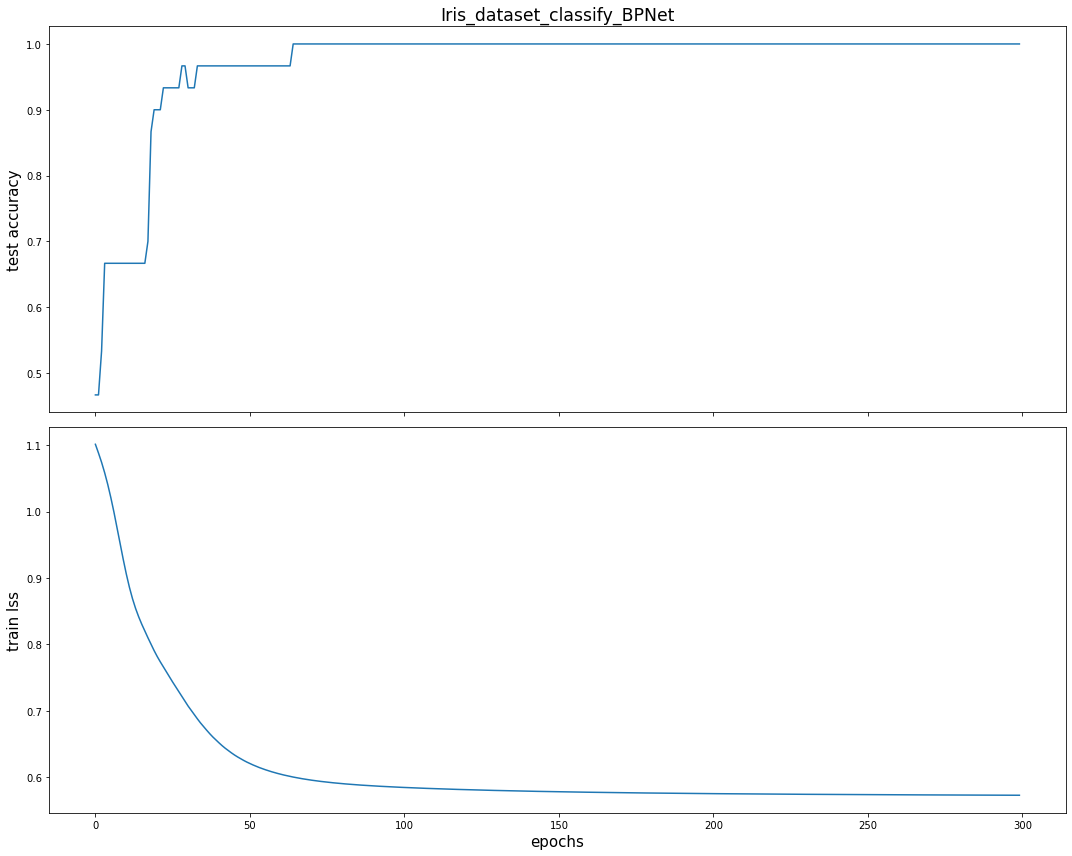

In [6]:
#5.绘制损失函数和精度
fig_name="Iris_dataset_classify_BPNet"
fontsize=15
fig,(ax1,ax2)=plt.subplots(2,figsize=(15,12),sharex=True)
ax1.plot(accuracy_steps)
ax1.set_ylabel("test accuracy",fontsize=fontsize)
ax1.set_title(fig_name,fontsize="xx-large")
ax2.plot(loss_steps)
ax2.set_ylabel("train lss",fontsize=fontsize)
ax2.set_xlabel("epochs",fontsize=fontsize)
plt.tight_layout()
plt.savefig(fig_name+'.png')
plt.show()

In [7]:
x_train.shape

torch.Size([120, 4])

In [8]:
x_train[0]

tensor([0.1471, 0.4583, 0.1017, 0.0417])